In [1]:
import glob
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
import prettypyplot as pplt

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [3]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)
import mdtraj_upside as mu

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")
pplt.load_cmaps()
pplt.load_colors()

In [5]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [6]:
ss_colormap = {
    "H": "C0",
    "B": "C1",
    "E": "C2",
    "G": "C3",
    "I": "C4",
    "T": "C5",
    "S": "C6",
    " ": "C7",
}

In [7]:
def convert_to_array(dssp, simplified=True):
    ans = np.zeros_like(dssp, dtype=int)
    if simplified:
        ans[np.where(dssp == "H")] = 0
        ans[np.where(dssp == "E")] = 1
        ans[np.where(dssp == "C")] = 2
    else:
        ans[np.where(dssp == "H")] = 0
        ans[np.where(dssp == "B")] = 1
        ans[np.where(dssp == "E")] = 2
        ans[np.where(dssp == "G")] = 3
        ans[np.where(dssp == "I")] = 4
        ans[np.where(dssp == "T")] = 5
        ans[np.where(dssp == "S")] = 6
        ans[np.where(dssp == " ")] = 7
    return ans

In [8]:
labels = [
    r"$\alpha$-helix",
    r"$\beta$-bridge",
    r"$\beta$-strand",
    r"$3_{10}$-helix",
    r"$\pi$-helix",
    "turn",
    "bend",
    "loop",
]

In [9]:
simple_labels = [r"$\alpha$-helix", r"$\beta$-strand", "coil"]

In [10]:
def load(temp):
    base_dir = f"/project/dinner/scguo/kaiB/dga/{temp}/q_bin/"
    files = [os.path.join(base_dir, f"q_tse_{i}.h5") for i in range(10)]
    traj = md.load(files)
    return traj

In [11]:
traj = load(87)
dssp = md.compute_dssp(traj, simplified=True)
dssp = convert_to_array(dssp, simplified=True)

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [12]:
dssp[0]

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0])

In [13]:
dssp.shape

(10000, 94)

In [14]:
def compute_per_res_prob_ss(dssp):
    total = len(dssp)
    prob_helix = np.count_nonzero(dssp == 0, axis=0) / total
    prob_strand = np.count_nonzero(dssp == 1, axis=0) / total
    prob_coil = np.count_nonzero(dssp == 2, axis=0) / total
    assert np.allclose(prob_helix + prob_strand + prob_coil, 1)
    return prob_helix, prob_strand, prob_coil

In [15]:
prob_helix, prob_strand, prob_coil = compute_per_res_prob_ss(dssp)

In [16]:
prob_helix.shape

(94,)

In [17]:
def draw_ss(ax, y):
    width = 1.0
    height = 0.001
    artists = [
        mpatches.Arrow(8, y, 6, 0, width=width),
        mpatches.FancyBboxPatch((20, y - height / 2), 15, height, ec="none"),
        mpatches.Arrow(40, y, 6, 0, width=width),
        mpatches.FancyBboxPatch((49, y - height / 2), 7, height, ec="none"),
        mpatches.Arrow(63, y, 6, 0, width=width),
        mpatches.Arrow(72, y, 5, 0, width=width),
        mpatches.FancyBboxPatch((83, y - height), 11, height, ec="none"),
    ]
    for artist in artists:
        artist.set(color="C1")
        ax.add_artist(artist)

    ss_locs = [11, 27, 43, 52, 66, 74, 88]
    ss_labels = [
        r"$\beta1$",
        r"$\alpha1$",
        r"$\beta2$",
        r"$\alpha2$",
        r"$\beta3$",
        r"$\beta4$",
        r"$\alpha3$",
    ]
    for x, label in zip(ss_locs, ss_labels):
        ax.text(x, y + 0.5, label, ha="center")
    return ax

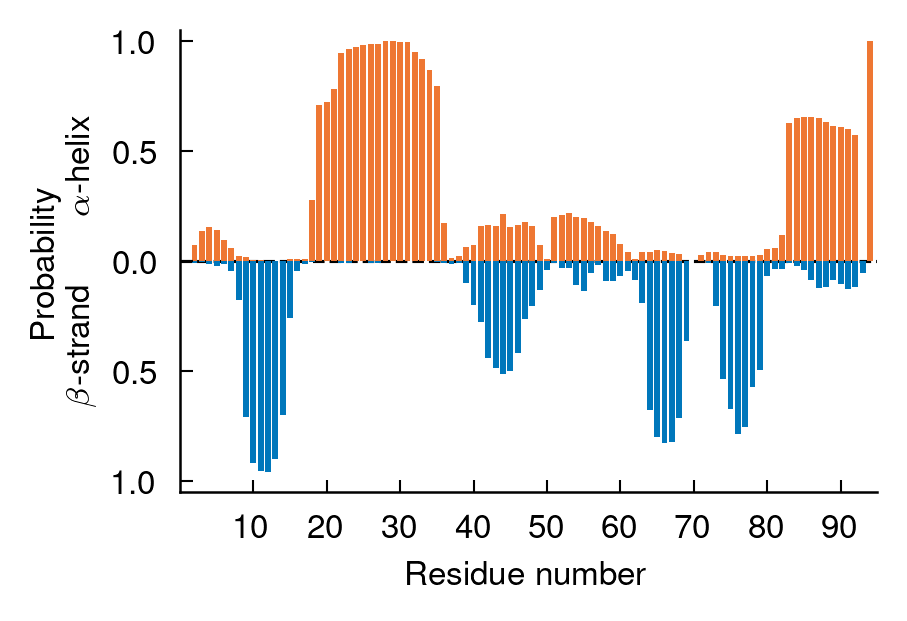

In [18]:
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.gca()

ax.bar(range(len(prob_coil)), prob_helix, color="C0", align='center')
ax.bar(range(len(prob_coil)), -prob_strand, color="C1", align='center')
ax.set_xlim([-1, len(prob_coil)])
ax.set_ylim([-1.05, 1.05])
# ax = draw_ss(ax, 1.25)
ax.set_xlabel("Residue number")
ax.set_ylabel("Probability\n$\\beta$-strand$\qquad$$\\alpha$-helix")
ax.set_xticks(np.arange(9, 99, 10), labels=np.arange(10, 100, 10))
ax.set_yticks(np.linspace(-1, 1, 5), labels=[1.0, 0.5, 0.0, 0.5, 1.0])

ax.axhline(0, ls="--", color="k", zorder=0)
sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)

In [19]:
cmap = mpl.colormaps["paula"]

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


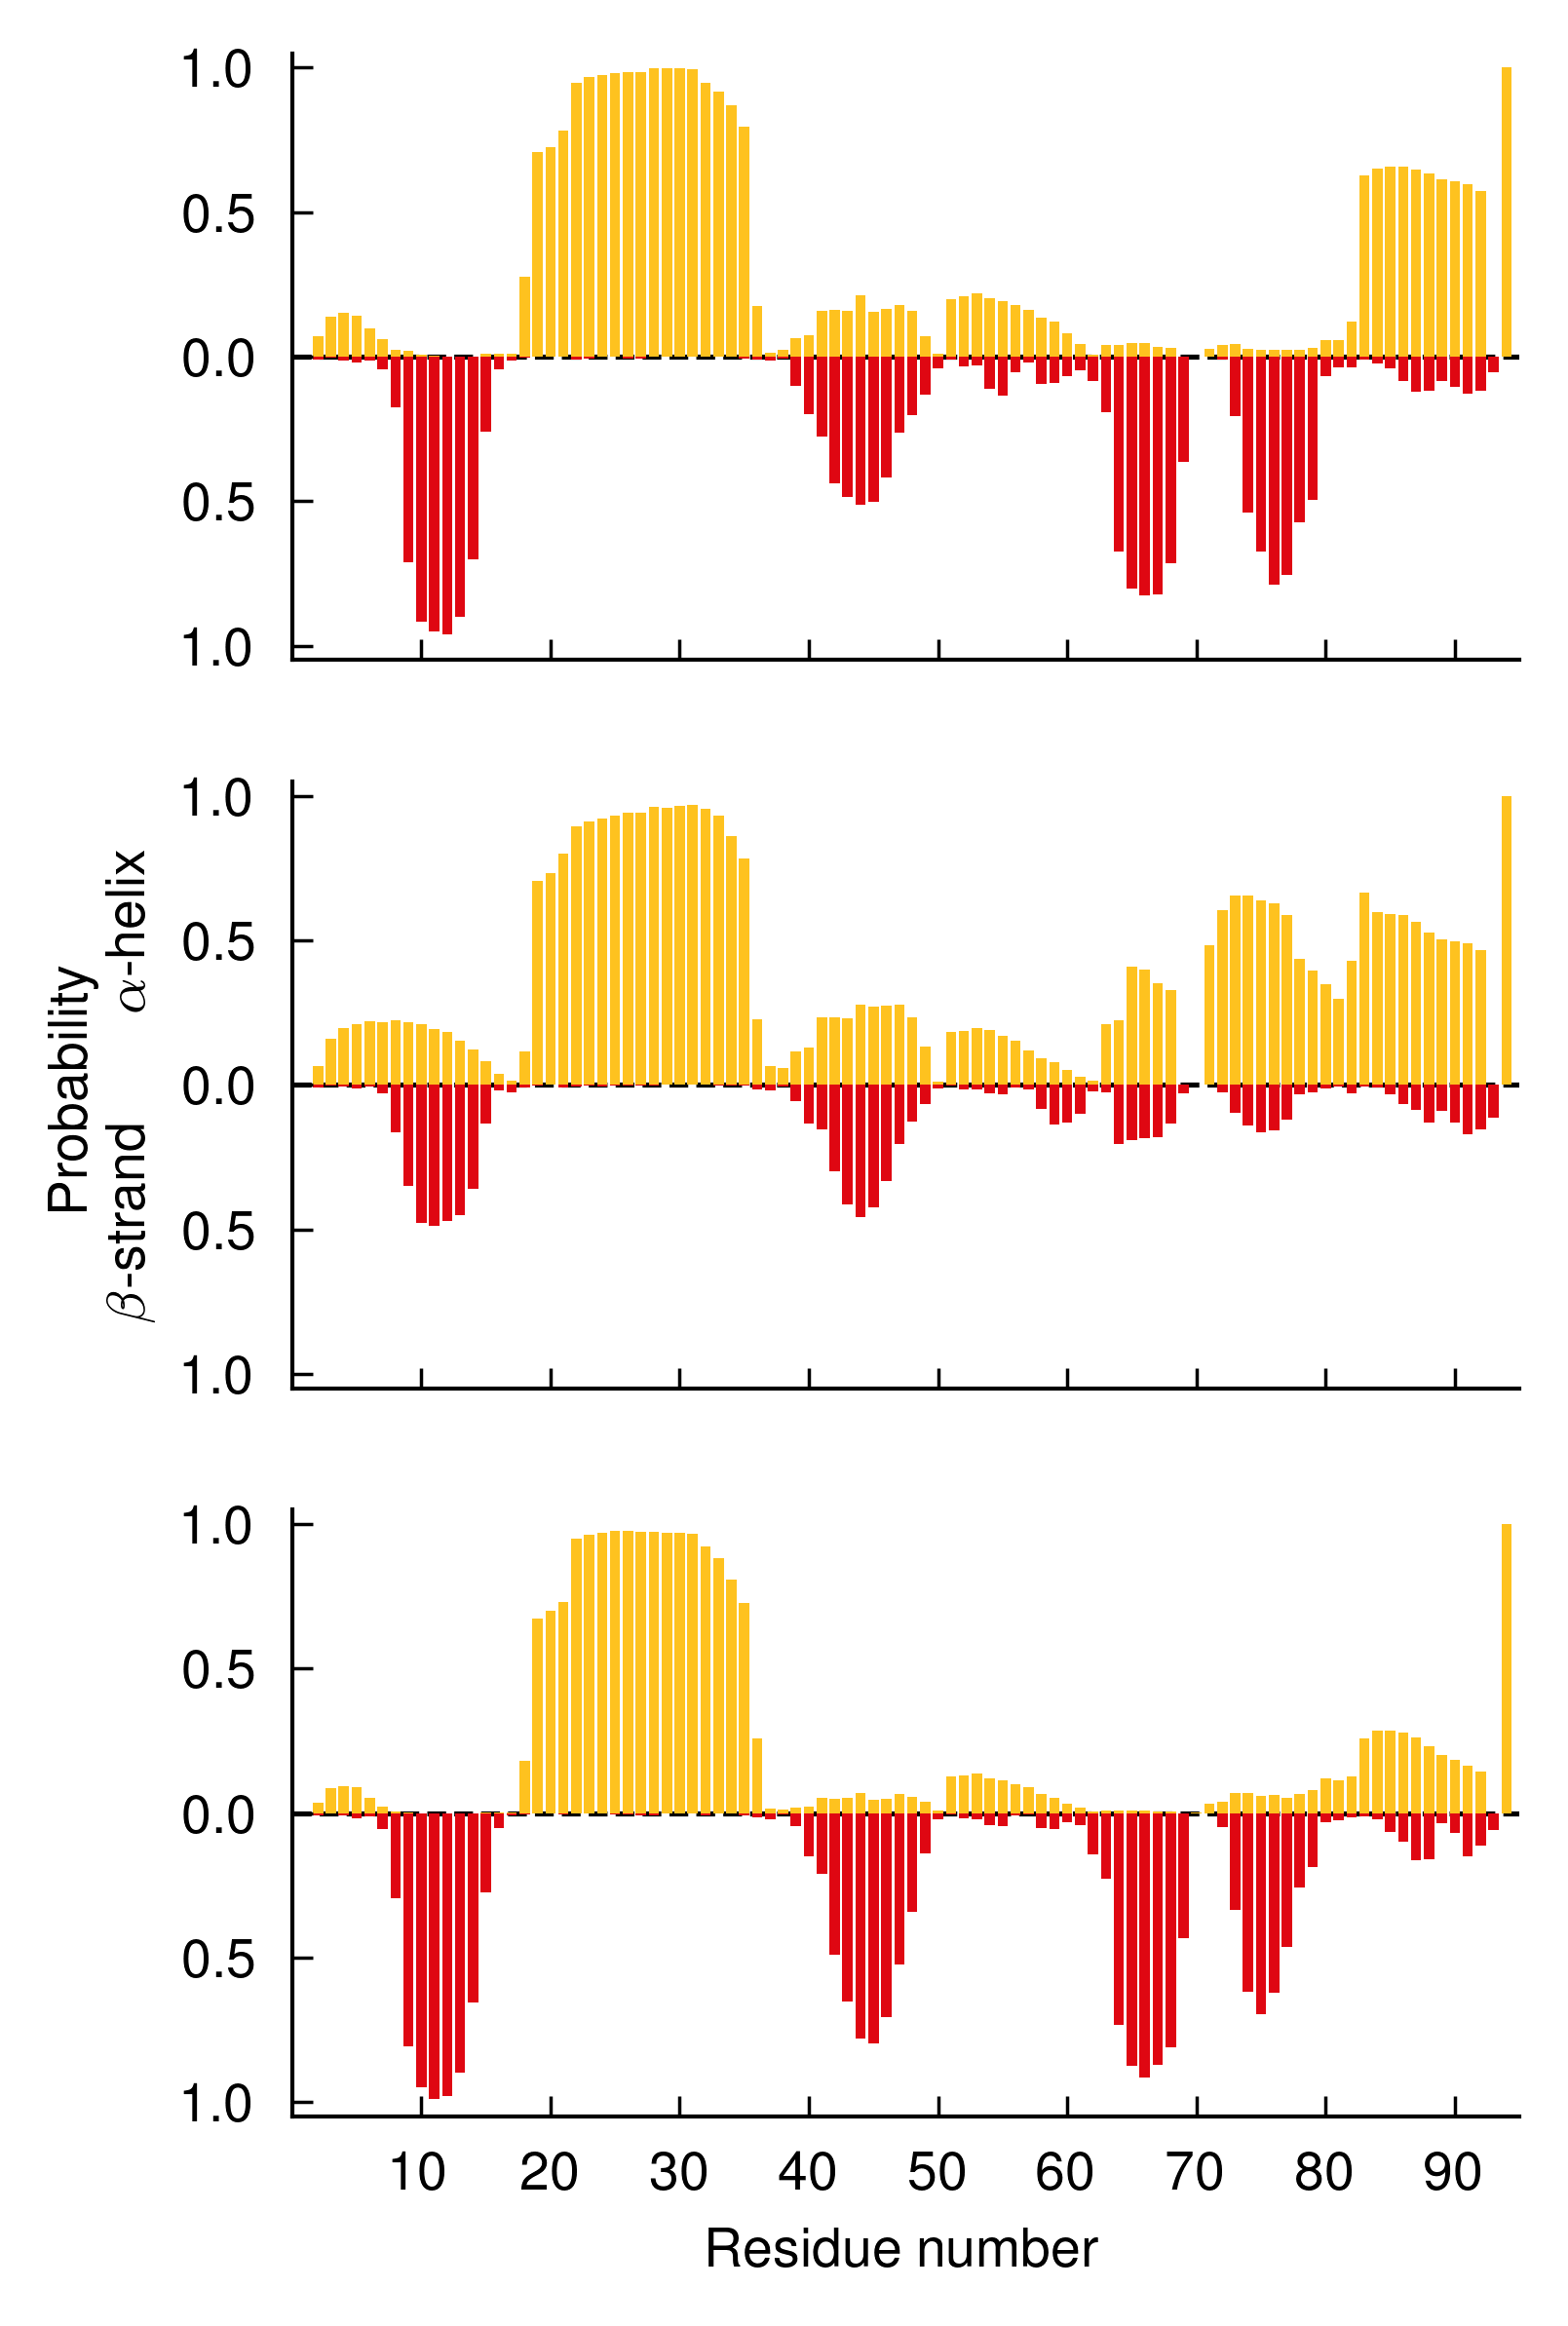

In [20]:
fig, axes = plt.subplots(nrows=3, figsize=(3.25, 5.5), dpi=500, sharex=True, sharey=True)
for ax, t in zip(axes, (87, 89, 91)):
    traj = load(t)
    dssp = md.compute_dssp(traj, simplified=True)
    dssp = convert_to_array(dssp, simplified=True)
    prob_helix, prob_strand, prob_coil = compute_per_res_prob_ss(dssp)
    
    ax.bar(range(len(prob_coil)), prob_helix, color=cmap.colors[0], align='center')
    ax.bar(range(len(prob_coil)), -prob_strand, color=cmap.colors[2], align='center')
    ax.set_xlim([-1, len(prob_coil)])
    ax.set_ylim([-1.05, 1.05])
    # ax = draw_ss(ax, 1.25)
    ax.set_xticks(np.arange(9, 99, 10), labels=np.arange(10, 100, 10))
    ax.set_yticks(np.linspace(-1, 1, 5), labels=[1.0, 0.5, 0.0, 0.5, 1.0])
    ax.axhline(0, ls="--", color="k", zorder=0)
    sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)

axes[2].set_xlabel("Residue number")
axes[1].set_ylabel("Probability\n$\\beta$-strand$\qquad$$\\alpha$-helix")
plt.savefig("../../dga/figures/dssp_tse.png", bbox_inches='tight')